<a href="https://colab.research.google.com/github/Aaronau667/FinRL-Tutorials/blob/master/1-Introduction/FinRL_PortfolioAllocation_NeurIPS_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-portfolio-allocation-9b417660c7cd
* Please report any issues to our Github: https://github.com/AI4Finance-Foundation/FinRL/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for portfolio alloacation. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A represents the weight of a stock in the porfolio: a ∈ (-1,1). Assume our stock pool includes N stocks, we can use a list [a<sub>1</sub>, a<sub>2</sub>, ... , a<sub>N</sub>] to determine the weight for each stock in the porfotlio, where a<sub>i</sub> ∈ (-1,1), a<sub>1</sub>+ a<sub>2</sub>+...+a<sub>N</sub>=1. For example, "The weight of AAPL in the portfolio is 10%." is [0.1 , ...].

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:

## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install pyportfolioopt
!pip install zipline-reloaded
!pip install ccxt
!pip install pandas_market_calendars
!pip install gym


✨🍰✨ Everything looks OK!
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-49pscy_n
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-49pscy_n
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 9175621d1235a335a667ee4796d7722e555a9e78
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-0420wb4o/elegantrl_0923f9fd2973469d85616a24df6fd2f3
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-0420wb4o/elegantrl_0923f9fd2973469d85616a24df6fd


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [4]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [5]:
start_date = '2008-01-01'
end_date = '2021-10-31'

In [6]:
import os
import pandas as pd
from datetime import datetime
import time
import random
import requests

def download_and_save_data(start_date, end_date, ticker_list, data_dir='./data'):

    # Create data storage directory
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Generate filename (using date range)
    file_name = f"dow30_data_{start_date}_{end_date}.csv"
    file_path = os.path.join(data_dir, file_name)

    # Check if file already exists
    if os.path.exists(file_path):
        print(f"Loading existing data from {file_path}")
        return pd.read_csv(file_path, index_col=0, parse_dates=True)

    print("Downloading data from Yahoo Finance...")
    # Use modified download function
    def download_with_retry(ticker, start_date, end_date, max_retries=3, delay=2):
        for attempt in range(max_retries):
            try:
                data = YahooDownloader(start_date=start_date,
                                     end_date=end_date,
                                     ticker_list=[ticker]).fetch_data()
                return data
            except Exception as e:
                if attempt < max_retries - 1:
                    sleep_time = delay + random.uniform(0, 1)
                    print(f"Download failed for {ticker}, retrying in {sleep_time:.2f} seconds...")
                    time.sleep(sleep_time)
                else:
                    print(f"Failed to download {ticker} after {max_retries} attempts")
                    raise e

    # Download all stock data
    all_data = []
    for ticker in ticker_list:
        try:
            data = download_with_retry(ticker, start_date, end_date)
            all_data.append(data)
            print(f"Successfully downloaded {ticker}")
        except Exception as e:
            print(f"Error downloading {ticker}: {str(e)}")

    # Merge all data
    if all_data:
        final_df = pd.concat(all_data, axis=0)
        # Save to CSV file
        final_df.to_csv(file_path)
        print(f"Data saved to {file_path}")
        return final_df
    else:
        raise Exception("No data was downloaded successfully")

# Use modified function
df = download_and_save_data(
    start_date=start_date,
    end_date=end_date,
    ticker_list=config_tickers.DOW_30_TICKER
)

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded AXP


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded AMGN


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded AAPL


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded BA


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded CAT


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded CSCO


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded CVX


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded GS


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded HD


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded HON


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded IBM


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded INTC


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded JNJ


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded KO


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded JPM


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded MCD


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded MMM


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded MRK


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded MSFT


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded NKE


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded PG


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded TRV


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded UNH


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded CRM


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded VZ


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3430, 8)
Successfully downloaded V


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded WBA


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded WMT


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3483, 8)
Successfully downloaded DIS


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (661, 8)
Successfully downloaded DOW
Data saved to ./data/dow30_data_2008-01-01_2021-10-31.csv


In [7]:
df.head()

Price,date,close,high,low,open,volume,tic,day
0,2008-01-02,38.898689,39.874204,38.708159,39.698916,8053700,AXP,2
1,2008-01-03,38.418541,39.249253,38.258496,39.020618,7753200,AXP,3
2,2008-01-04,37.450653,38.098458,37.122941,38.098458,8501400,AXP,4
3,2008-01-07,37.618340,38.182308,37.031505,37.747899,14031100,AXP,0
4,2008-01-08,36.543736,37.877448,36.398931,37.877448,11721000,AXP,1


In [8]:
df.shape

(101615, 8)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
import os
import pandas as pd

# 检查处理后的文件是否存在
processed_file_path = f"data/dow30_data_{start_date}_{end_date}_processed.csv"

if os.path.exists(processed_file_path):
    print(f"找到已处理的特征工程文件: {processed_file_path}，直接读取数据...")
    df = pd.read_csv(processed_file_path)
    # 如果需要将字符串日期转换回datetime对象
    if 'date' in df.columns and isinstance(df['date'].iloc[0], str):
        df['date'] = pd.to_datetime(df['date'])
else:
    print(f"未找到已处理的特征工程文件，开始处理数据...")
    # 特征工程处理
    fe = FeatureEngineer(
        use_technical_indicator=True,
        use_turbulence=False,
        user_defined_feature=False)

    df = fe.preprocess_data(df)

    # 创建data目录(如果不存在)
    if not os.path.exists('data'):
        os.makedirs('data')

    # 将处理后的数据保存到data目录
    df.to_csv(processed_file_path, index=False)
    print(f"特征工程处理完成并保存至: {processed_file_path}")


未找到已处理的特征工程文件，开始处理数据...
Successfully added technical indicators
特征工程处理完成并保存至: data/dow30_data_2008-01-01_2021-10-31_processed.csv


In [10]:
df.shape

(97524, 16)

In [11]:
df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,5.855758,6.018652,5.786934,5.988898,1079178800,AAPL,2,0.0,5.860937,5.853284,100.0,-66.666667,100.0,5.855758,5.855758
3483,2008-01-02,32.223793,32.528054,31.988684,32.223793,7934400,AMGN,2,0.0,5.860937,5.853284,100.0,-66.666667,100.0,32.223793,32.223793
6966,2008-01-02,38.898689,39.874204,38.708159,39.698916,8053700,AXP,2,0.0,5.860937,5.853284,100.0,-66.666667,100.0,38.898689,38.898689
10449,2008-01-02,63.481617,64.375720,63.027233,64.177846,4303000,BA,2,0.0,5.860937,5.853284,100.0,-66.666667,100.0,63.481617,63.481617
13932,2008-01-02,44.507298,45.792798,44.141816,45.723482,6337800,CAT,2,0.0,5.860937,5.853284,100.0,-66.666667,100.0,44.507298,44.507298


## Add covariance matrix as states

In [12]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values
  cov_list.append(covs)


df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [13]:
df.shape

(90468, 18)

In [14]:
df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,2.565124,2.636954,2.564824,2.583758,607541200,AAPL,2,-0.082003,3.071161,2.436449,42.254768,-80.847305,16.129881,2.729571,2.840867,"[[0.001348968010512731, 0.0004284116657854643,...",tic AAPL AMGN AXP ...
1,2008-12-31,39.933990,40.258995,39.456858,39.491432,6287200,AMGN,2,0.149619,40.761995,38.992591,51.060606,51.894903,10.431939,39.188099,38.754530,"[[0.001348968010512731, 0.0004284116657854643,...",tic AAPL AMGN AXP ...
2,2008-12-31,14.326875,14.481343,13.832579,13.878919,9625600,AXP,2,-0.919293,18.322191,12.440031,42.554858,-74.811404,25.744710,15.469930,17.309638,"[[0.001348968010512731, 0.0004284116657854643,...",tic AAPL AMGN AXP ...
3,2008-12-31,32.005894,32.290925,31.128302,31.195809,5443100,BA,2,-0.279799,32.174389,28.867832,47.440254,157.922633,5.792027,30.327213,32.389914,"[[0.001348968010512731, 0.0004284116657854643,...",tic AAPL AMGN AXP ...
4,2008-12-31,28.895700,29.173855,28.268238,28.268238,6277400,CAT,2,0.639826,29.617325,24.842683,51.205323,98.904844,26.480648,26.046878,25.787323,"[[0.001348968010512731, 0.0004284116657854643,...",tic AAPL AMGN AXP ...


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.


## Training data split: 2009-01-01 to 2020-07-01

In [15]:
train = data_split(df, '2009-01-01','2020-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [16]:
train.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,2.727417,2.736134,2.559415,2.581054,746015200,AAPL,4,-0.069643,3.057737,2.434395,45.440198,-30.508582,2.140071,2.730413,2.841663,"[[0.0013661497811316245, 0.0004339373252529716...",tic AAPL AMGN AXP ...
0,2009-01-02,40.791462,40.853697,39.934003,40.514862,6547900,AMGN,4,0.221591,40.900960,38.958735,52.756878,94.549974,0.813921,39.249182,38.838662,"[[0.0013661497811316245, 0.0004339373252529716...",tic AAPL AMGN AXP ...
0,2009-01-02,14.929294,15.076038,14.211019,14.342317,10955700,AXP,4,-0.817562,18.141773,12.424275,43.957553,-42.018819,16.306939,15.468643,17.194817,"[[0.0013661497811316245, 0.0004339373252529716...",tic AAPL AMGN AXP ...
0,2009-01-02,33.941097,34.173623,32.088400,32.103402,7010200,BA,4,-0.002007,32.948631,28.452127,50.822035,275.696179,20.866022,30.469478,32.344129,"[[0.0013661497811316245, 0.0004339373252529716...",tic AAPL AMGN AXP ...
0,2009-01-02,30.344687,30.389967,28.921571,29.050946,7117200,CAT,4,0.813122,30.107334,24.822303,53.661255,131.675982,34.780786,26.278027,25.787890,"[[0.0013661497811316245, 0.0004339373252529716...",tic AAPL AMGN AXP ...


## Environment for Portfolio Allocation


In [17]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step


    """
    metadata = {'render.modes': ['human']}

    def __init__(self,
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]


    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()

            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")

            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions)
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]
        return self.state

    def render(self, mode='human'):
        return self.state

    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output


    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']

        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [18]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 28, State Space: 28


In [19]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [20]:
# 首先安装必要的shimmy包
!pip install 'shimmy>=2.0'

import numpy as np
import gym
import gymnasium
from stable_baselines3.common.vec_env import DummyVecEnv

# 创建一个适配器类，需要继承自gym.Env
class CompatibilityWrapper(gym.Env):
    """兼容性包装器，用于在新版SB3中使用旧版Gym环境"""

    def __init__(self, env):
        """
        参数:
            env: 需要包装的环境
        """
        self.env = env

        # 复制环境的属性
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        self.metadata = getattr(env, 'metadata', {'render_modes': ['human']})
        self.reward_range = getattr(env, 'reward_range', (-float('inf'), float('inf')))

    def reset(self, **kwargs):
        """适配reset方法"""
        # 调用原始环境的reset
        obs = self.env.reset()
        # 返回适配后的结果
        return obs, {}

    def step(self, action):
        """适配step方法"""
        # 调用原始环境的step
        obs, reward, done, info = self.env.step(action)
        # 返回适配后的结果
        if not isinstance(info, dict):
            info = {}
        return obs, reward, done, False, info

    def render(self, mode='human'):
        """适配render方法"""
        return self.env.render(mode)

    def close(self):
        """关闭环境"""
        return self.env.close()

    def seed(self, seed=None):
        """设置随机种子"""
        return self.env.seed(seed) if hasattr(self.env, 'seed') else None

    # 转发所有其他方法和属性到原始环境
    def __getattr__(self, name):
        return getattr(self.env, name)

    @property
    def unwrapped(self):
        return self.env.unwrapped

# 直接从DummyVecEnv创建向量化环境的函数
def direct_dummy_vec_env(env_instance):
    """直接创建DummyVecEnv，跳过_patch_env检查"""
    from stable_baselines3.common.vec_env.base_vec_env import VecEnvIndices
    from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv

    class DirectDummyVecEnv(DummyVecEnv):
        def __init__(self, env_instance):
            self.envs = [env_instance]
            self.env_method_name = None
            self.observation_space = env_instance.observation_space
            self.action_space = env_instance.action_space
            self.num_envs = 1
            self.class_attributes = dir(self.__class__)

            # For backwards compatibility with SB <2.10.0
            if getattr(env_instance, "metadata", None) is not None:
                self.metadata = env_instance.metadata

        def reset(self):
            obs = self.envs[0].reset()
            return np.array([obs])

        def step_async(self, actions):
            self.actions = actions

        def step_wait(self):
            obs, rewards, dones, infos = self.envs[0].step(self.actions[0])
            return np.array([obs]), np.array([rewards]), np.array([dones]), [infos]

        def get_attr(self, attr_name: str, indices: VecEnvIndices = None):
            return [getattr(self.envs[0], attr_name)]

    # 创建并返回直接的DummyVecEnv
    vec_env = DirectDummyVecEnv(env_instance)
    obs = vec_env.reset()
    return vec_env, obs

# 覆盖原始的get_sb_env方法
def get_compatible_env(env_instance):
    """获取与SB3兼容的环境"""
    # 首先尝试直接方法
    try:
        wrapped_env = CompatibilityWrapper(env_instance)
        return direct_dummy_vec_env(wrapped_env)
    except Exception as e1:
        print(f"直接方法失败: {e1}")

        # 尝试其他方法
        try:
            wrapped_env = CompatibilityWrapper(env_instance)
            vec_env = DummyVecEnv([lambda: wrapped_env])
            obs = vec_env.reset()
            return vec_env, obs
        except Exception as e2:
            print(f"标准方法也失败: {e2}")

            # 最后的备选方案
            vec_env = DummyVecEnv([lambda: env_instance])
            obs = np.array([env_instance.reset()])
            return vec_env, obs

# 替换环境的get_sb_env方法
e_train_gym.get_sb_env = lambda: get_compatible_env(e_train_gym)

# 获取环境
env_train, obs_train = e_train_gym.get_sb_env()
print(f"环境类型: {type(env_train)}")
print(f"观察形状: {obs_train.shape}")

直接方法失败: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.
标准方法也失败: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.
环境类型: <class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
观察形状: (1, 36, 28)


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [21]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

直接方法失败: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.
标准方法也失败: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [ ]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


d:\0Awork\Envs\FinRL311\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=50000)

-------------------------------------
| time/                 |           |
|    fps                | 306       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -39.6     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.99e+08  |
|    reward             | 1674928.5 |
|    std                | 0.997     |
|    value_loss         | 2.96e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 340       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -39.6     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0002    |
|    n_updat

In [ ]:
trained_a2c.save('/content/trained_models/trained_a2c.zip')

d:\0Awork\Envs\FinRL311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path '\content\trained_models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


### Model 2: **PPO**


In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


d:\0Awork\Envs\FinRL311\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=80000)

----------------------------------
| time/              |           |
|    fps             | 473       |
|    iterations      | 1         |
|    time_elapsed    | 4         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 4187343.2 |
----------------------------------
begin_total_asset:1000000
end_total_asset:6219425.100762817
Sharpe:  0.9616967469942584
-------------------------------------------
| time/                   |               |
|    fps                  | 443           |
|    iterations           | 2             |
|    time_elapsed         | 9             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.2776582e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -39.7         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                

In [ ]:
trained_ppo.save('/content/trained_models/trained_ppo.zip')

### Model 3: **DDPG**


In [ ]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:5991905.415366534
Sharpe:  0.9516814560416598
begin_total_asset:1000000
end_total_asset:5773161.546049173
Sharpe:  0.938510014499584
begin_total_asset:1000000
end_total_asset:5773161.546049173
Sharpe:  0.938510014499584
begin_total_asset:1000000
end_total_asset:5773161.546049173
Sharpe:  0.938510014499584
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 171       |
|    time_elapsed    | 67        |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -1.32e+08 |
|    critic_loss     | 2.12e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 11471     |
|    reward          | 5773161.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:5773161.546049173
Sharpe:  0.938510014499584
begin_total_asset:1000000
end_total_asset:5773161.546049173
Sharpe:  0.938510014499584
begin_total_asset:1000

In [ ]:
trained_ddpg.save('/content/trained_models/trained_ddpg.zip')

### Model 4: **SAC**


In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [ ]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:5249644.459073269
Sharpe:  0.8664866862981275
begin_total_asset:1000000
end_total_asset:5239085.284049942
Sharpe:  0.8609730122553975
begin_total_asset:1000000
end_total_asset:5239115.384031524
Sharpe:  0.8609780588999454
begin_total_asset:1000000
end_total_asset:5239257.278383997
Sharpe:  0.8609900444457859
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 115       |
|    time_elapsed    | 100       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -1.3e+08  |
|    critic_loss     | 1.62e+12  |
|    ent_coef        | 3.27      |
|    ent_coef_loss   | -203      |
|    learning_rate   | 0.0003    |
|    n_updates       | 11471     |
|    reward          | 5239257.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:5239296.366233305
Sharpe:  0.8609964721456198
begin_total_asset:1000000
end_total

In [ ]:
trained_sac.save('/content/trained_models/trained_sac.zip')

### Model 5: **TD3**


In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=30000)

begin_total_asset:1000000
end_total_asset:5675416.513683438
Sharpe:  0.9077117517411494
begin_total_asset:1000000
end_total_asset:5739348.733838461
Sharpe:  0.9029069523094823
begin_total_asset:1000000
end_total_asset:5739348.733838461
Sharpe:  0.9029069523094823
begin_total_asset:1000000
end_total_asset:5739348.733838461
Sharpe:  0.9029069523094823
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 183       |
|    time_elapsed    | 62        |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -7.72e+07 |
|    critic_loss     | 8.87e+11  |
|    learning_rate   | 0.001     |
|    n_updates       | 11471     |
|    reward          | 5739348.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:5739348.733838461
Sharpe:  0.9029069523094823
begin_total_asset:1000000
end_total_asset:5739348.733838461
Sharpe:  0.9029069523094823
begin_total_asset

In [ ]:
trained_td3.save('/content/trained_models/trained_td3.zip')

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [22]:
trade = data_split(df,'2020-07-01', '2021-10-31')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [23]:
trade.shape

(9436, 18)

In [24]:
import os
import pandas as pd
from stable_baselines3 import A2C
from finrl.agents.stablebaselines3.models import DRLAgent

def load_model_and_predict(model_path, environment):
    """
    从本地目录加载训练好的模型并在已有环境上进行预测

    参数:
    model_path (str): 模型文件的路径，例如 './trained_models/trained_a2c.zip'
    environment: 已经初始化的交易环境对象

    返回:
    tuple: (df_daily_return, df_actions) 每日回报数据和动作数据
    """
    # 检查模型文件是否存在
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"模型文件不存在: {model_path}")

    print(f"从本地加载模型: {model_path}")

    # 加载模型并进行预测
    try:
        # 创建DRLAgent实例
        agent = DRLAgent(env=environment)

        # 加载已训练的模型
        loaded_model = agent.get_model("a2c")  # 创建一个新的模型实例
        loaded_model.load(model_path)  # 加载保存的权重

        print("模型加载成功，开始预测...")
        df_daily_return, df_actions = DRLAgent.DRL_prediction(
            model=loaded_model,
            environment=environment
        )

        # 保存结果到本地
        os.makedirs("./results", exist_ok=True)
        df_daily_return.to_csv("./results/df_daily_return.csv", index=False)
        df_actions.to_csv("./results/df_actions.csv", index=False)

        print(f"预测结果已保存到 ./results/ 目录")

        return df_daily_return, df_actions

    except Exception as e:
        print(f"预测过程中出错: {str(e)}")
        raise

In [26]:
# 假设e_trade_gym已经在你的环境中初始化好了
model_path = "/content/trained_models/trained_a2c.zip"
df_daily_return, df_actions = load_model_and_predict(model_path, e_trade_gym)

从本地加载模型: /content/trained_models/trained_a2c.zip
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


模型加载成功，开始预测...


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000000
end_total_asset:1423714.8713819843
Sharpe:  2.004260007502546
hit end!
预测结果已保存到 ./results/ 目录


In [28]:
df_daily_return.head()

,date,daily_return
0,2020-07-01,0.000000
1,2020-07-02,0.004614
2,2020-07-06,0.015925
3,2020-07-07,-0.013794
4,2020-07-08,0.005647


In [29]:
df_daily_return.to_csv('df_daily_return.csv')

In [30]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
2020-07-02,0.035645,0.035893,0.035674,0.035645,0.035739,0.035645,0.035825,0.035645,0.035694,0.035817,...,0.035717,0.035645,0.035879,0.035934,0.035645,0.035893,0.035645,0.035745,0.035645,0.035645
2020-07-06,0.035645,0.035886,0.035715,0.035645,0.035791,0.035645,0.035895,0.035645,0.035645,0.035810,...,0.035645,0.035645,0.035893,0.035918,0.035645,0.035901,0.035645,0.035727,0.035645,0.035645
2020-07-07,0.035632,0.035859,0.035714,0.035632,0.035741,0.035632,0.035777,0.035632,0.035632,0.035975,...,0.035751,0.035632,0.035866,0.035952,0.035632,0.035792,0.035632,0.035844,0.035632,0.035675
2020-07-08,0.035641,0.035795,0.035682,0.035641,0.035684,0.035641,0.035707,0.035641,0.035641,0.035999,...,0.035826,0.035641,0.035886,0.035967,0.035641,0.035803,0.035641,0.035825,0.035641,0.035696


In [31]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [32]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats
perf_stats_all = perf_func( returns=DRL_strat,
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

In [33]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


,0
Annual return,0.302344
Cumulative returns,0.423715
Annual volatility,0.136506
Sharpe ratio,2.004260
Calmar ratio,3.611168
Stability,0.919429
Max drawdown,-0.083725
Omega ratio,1.396812
Sortino ratio,3.057870
Skew,-0.143062


In [34]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (336, 8)
Annual return          0.279047
Cumulative returns     0.388402
Annual volatility      0.139129
Sharpe ratio           1.844560
Calmar ratio           3.124551
Stability              0.918675
Max drawdown          -0.089308
Omega ratio            1.358960
Sortino ratio          2.734872
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016510
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (337, 8)



/usr/local/lib/python3.11/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.234%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2020-07-01
End date,2021-10-29
Total months,16
,Backtest
Annual return,30.234%
Cumulative returns,42.371%
Annual volatility,13.651%
Sharpe ratio,2.00
Calmar ratio,3.61
Stability,0.92
Max drawdown,-8.372%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.37,2020-09-02,2020-10-28,2020-11-09,49
1,4.40,2021-08-16,2021-09-21,2021-10-20,48
2,3.90,2021-06-04,2021-06-18,2021-07-02,21
3,3.58,2021-01-21,2021-01-29,2021-02-05,12
4,3.20,2021-02-24,2021-03-04,2021-03-10,11


/usr/local/lib/python3.11/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.11%,-3.27%,3.80%


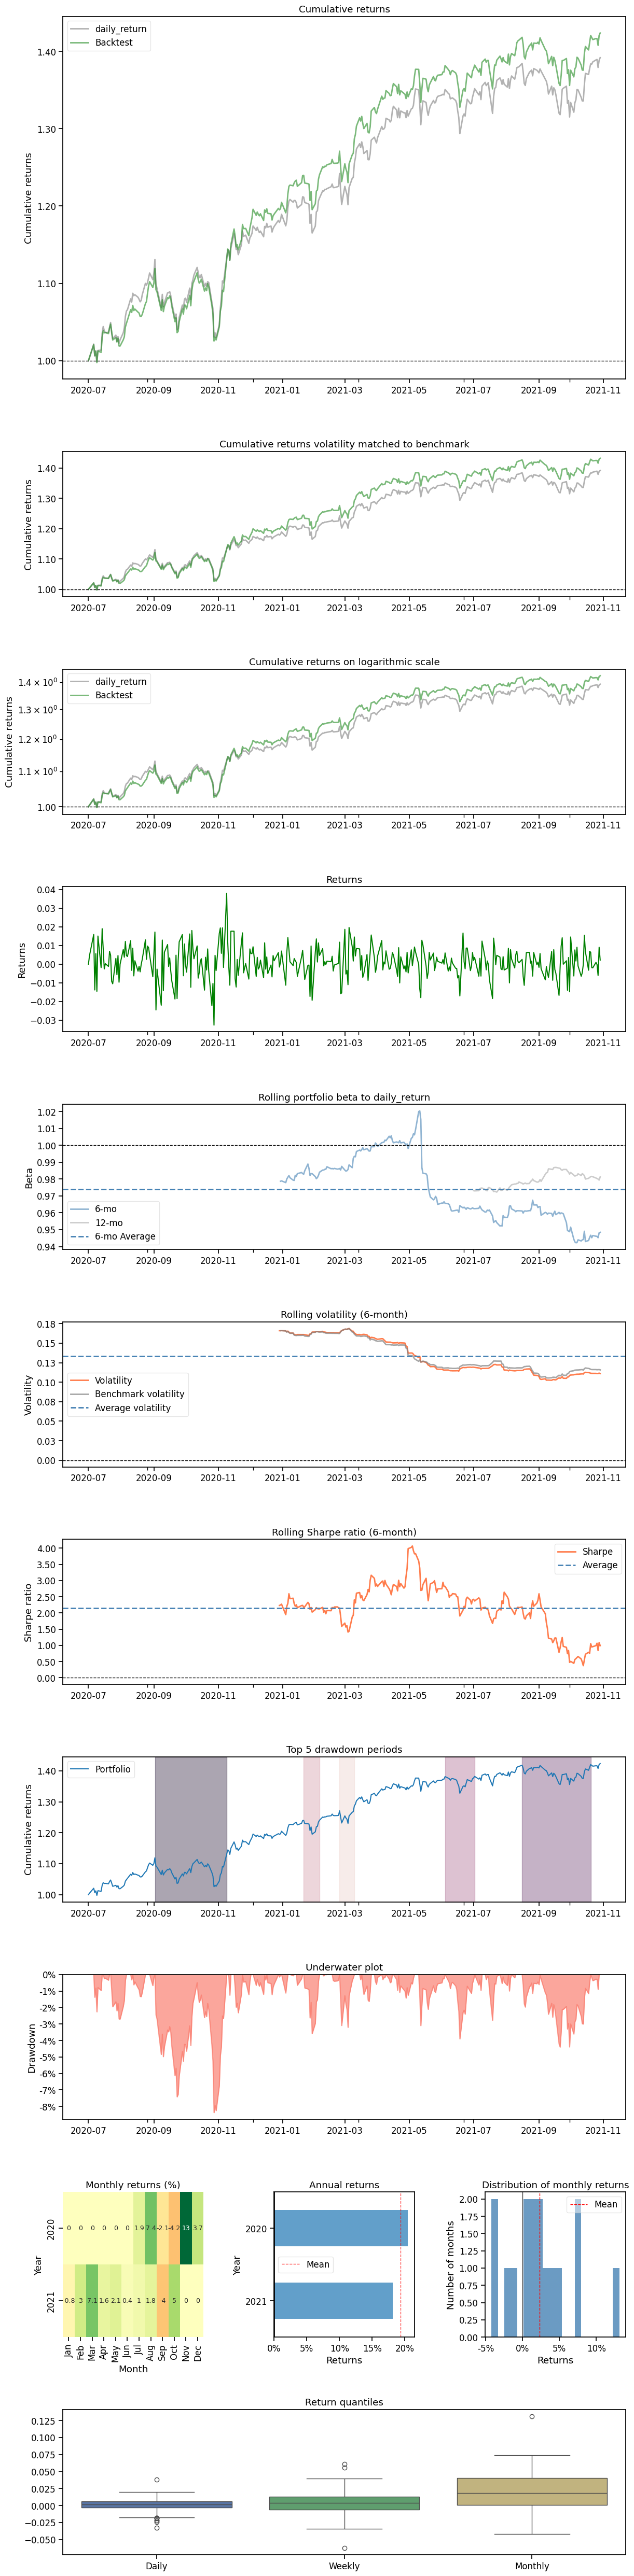

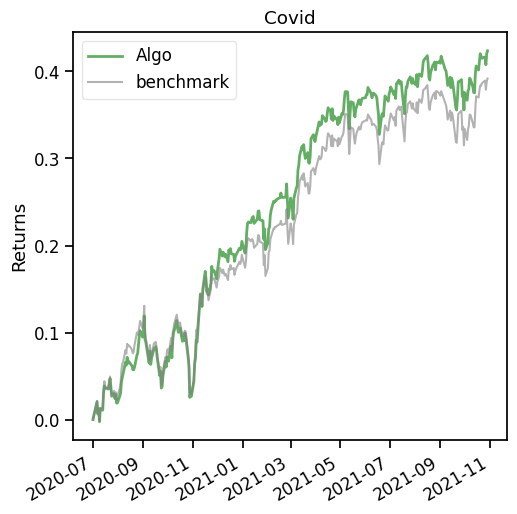

In [35]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-11-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

## Min-Variance Portfolio Allocation

In [36]:
%pip install PyPortfolioOpt

In [37]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [38]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [39]:
df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,2.565124,2.636954,2.564824,2.583758,607541200,AAPL,2,-0.082003,3.071161,2.436449,42.254768,-80.847305,16.129881,2.729571,2.840867,"[[0.001348968010512731, 0.0004284116657854643,...",tic AAPL AMGN AXP ...
1,2008-12-31,39.933990,40.258995,39.456858,39.491432,6287200,AMGN,2,0.149619,40.761995,38.992591,51.060606,51.894903,10.431939,39.188099,38.754530,"[[0.001348968010512731, 0.0004284116657854643,...",tic AAPL AMGN AXP ...
2,2008-12-31,14.326875,14.481343,13.832579,13.878919,9625600,AXP,2,-0.919293,18.322191,12.440031,42.554858,-74.811404,25.744710,15.469930,17.309638,"[[0.001348968010512731, 0.0004284116657854643,...",tic AAPL AMGN AXP ...
3,2008-12-31,32.005894,32.290925,31.128302,31.195809,5443100,BA,2,-0.279799,32.174389,28.867832,47.440254,157.922633,5.792027,30.327213,32.389914,"[[0.001348968010512731, 0.0004284116657854643,...",tic AAPL AMGN AXP ...
4,2008-12-31,28.895700,29.173855,28.268238,28.268238,6277400,CAT,2,0.639826,29.617325,24.842683,51.205323,98.904844,26.480648,26.046878,25.787323,"[[0.001348968010512731, 0.0004284116657854643,...",tic AAPL AMGN AXP ...


In [40]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()

    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)

portfolio=portfolio.T
portfolio.columns = ['account_value']

In [41]:
portfolio.head()

,account_value
2020-07-01,1000000
2020-07-02,1005253.956982
2020-07-06,1014938.51294
2020-07-07,1014208.543732
2020-07-08,1012633.830981


In [42]:
a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1

In [43]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

<ipython-input-43-2a1c4bec35f1>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1


In [44]:
dji_cumpod =(baseline_returns+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [45]:
%pip install plotly

In [46]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [47]:
time_ind = pd.Series(df_daily_return.date)

In [48]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [49]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2

    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date',
       'tick0': time_ind[0],
        'tickmode': 'linear',
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()